In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from copy import deepcopy
from datetime import datetime
from util.dataloader import *
from util.preprocessing import *
from util.formatting import *
from util.plot import *

# load cached bison data; replace filepath/dataloading as appropriate
# filepath = "/Users/audreyder/Neuralix/syncdatabase_{}.csv".format(datetime.now())
# data = fetch_bison_data(filepath)
filepath = "/Users/audreyder/Neuralix/syncdatabase_2025-01-24.csv"
data = cached_bison_data(filepath)
print(data.iloc[0]['timestamp'])
print(data.iloc[-1]['timestamp'])


Data columns: Index(['site_id', 'pump_id', 'timestamp', 'facility_name', 'vibration',
       'thrust temperature', 'suction pressure', 'discharge pressure',
       'flow rate', 'frequency', 'amps', 'ampsa', 'ampsb', 'ampsc', 'volts',
       'voltsa', 'voltsb', 'voltsc', 'meter total'],
      dtype='object')
Number of rows: 143684
2024-11-23 12:35:11
2025-01-24 12:34:03


In [2]:
site_ids = np.unique(data['site_id'])
site_bounds = {site_id: None for site_id in site_ids}
for site_id in site_ids:
    site_data = data[data['site_id']==site_id]
    site_bounds[site_id] = (site_data.iloc[0].name, site_data.iloc[-1].name)
print(site_bounds)

{np.int64(33404): (np.int64(0), np.int64(17926)), np.int64(33467): (np.int64(17927), np.int64(35984)), np.int64(33614): (np.int64(35985), np.int64(54523)), np.int64(57740): (np.int64(54524), np.int64(143683))}


In [3]:
twohr_rate_1_min = 120
twohr_rate_5_min = 24

# NOTES
# union city: 33404, one minute -- '2024-12-17 12:00:00'
# siegrist: 33467, five minutes -- '2024-12-17 10:00:00'
# canadian: 57740, one minutes -- '2024-12-13 12:00:00'
# calumet: 33614, five minutes -- '2024-12-13 12:00:00' 69969 is ~midnight sept 1 2024

# OLD -- found starting times based on the above notes by hand
# unioncity_start = 259943 
# seigrist_start = 66050 
# canadian_start = 254170 
# calumet_start = 100021

# Stage 1: Estimate time stamps for when each stage of calibration is happening given a label for when (date, time) calibration begins for a site
# 1. begin with your site id
# 2. specify your query start date and time for calibration 
# 3. find the closest time and date match in the dataframe to your query (default time is 00:00:00 if no time is specified)
# 4. hardcode the different frequencies you know are being calibrated # (Stage 2: automate this based on info given in steps 2 and 3 here)
# 5. format the estimated ground truth for calibration
# 6. plot it

unioncity_id = 33404 # 1
unioncity_startdate = '2024-12-17' # 2
unioncity_startime = '12:00:00'
unioncity_timestamp, unioncity_start = find_closest_time(data[data['site_id']==unioncity_id], unioncity_startdate, query_time=unioncity_startime) # 3
print(unioncity_timestamp)
unioncity_freqs = [46,48,50,52,54,56] # 4
unioncity = format_sitegts(unioncity_start,unioncity_freqs,twohr_rate_5_min) # 5

siegrist_id = 33467
seigrist_startdate = '2024-12-17'
seigrist_starttime = '10:00:00'
seigrist_timestamp, seigrist_start = find_closest_time(data[data['site_id']==siegrist_id], seigrist_startdate, query_time=seigrist_starttime)
seigrist_freqs = [47,49,51,53,55,57] # future: automate based on the above given timestamp
print(seigrist_timestamp)
siegrist = format_sitegts(seigrist_start,seigrist_freqs,twohr_rate_5_min) 

canadian_id = 57740
canadian_startdate = '2024-12-13'
canadian_starttime = '12:00:00'
canadian_timestamp, canadian_start = find_closest_time(data[data['site_id']==canadian_id], canadian_startdate, query_time=canadian_starttime)
print(canadian_timestamp, canadian_start)
canadian_freqs = [44,47,49,51,53,55,57,59] # future: automate based on the above given timestamp
canadian = format_sitegts(canadian_start,canadian_freqs,twohr_rate_1_min)

calumet_id = 33614
calumet_startdate = '2025-01-15'
calumet_starttime = '15:00:00'
calumet_timestamp, calumet_start = find_closest_time(data[data['site_id']==calumet_id], calumet_startdate, query_time=calumet_starttime)
print(calumet_timestamp, calumet_start)
calumet_freqs = [48,50,52,54,56,58] # future: automate based on the above given timestamp
calumet = format_sitegts(calumet_start,calumet_freqs,twohr_rate_5_min)

sitegts = {unioncity_id:unioncity, siegrist_id:siegrist, canadian_id:canadian, calumet_id:calumet}

# QUICK COMMANDS -- feel free to ignore
# print(data[data['site_id']==33614]) # look at the data for a given site
# s_temp = 100461
# print(data[s_temp:s_temp+twohr_rate_5_min][['timestamp','flow rate']]) # quickly check the two hour duration based off a start index & given sampling rate

2024-12-17 12:00:12
2024-12-17 10:00:19
2024-12-13 12:00:02 83263
2025-01-15 15:00:19 51800


33404


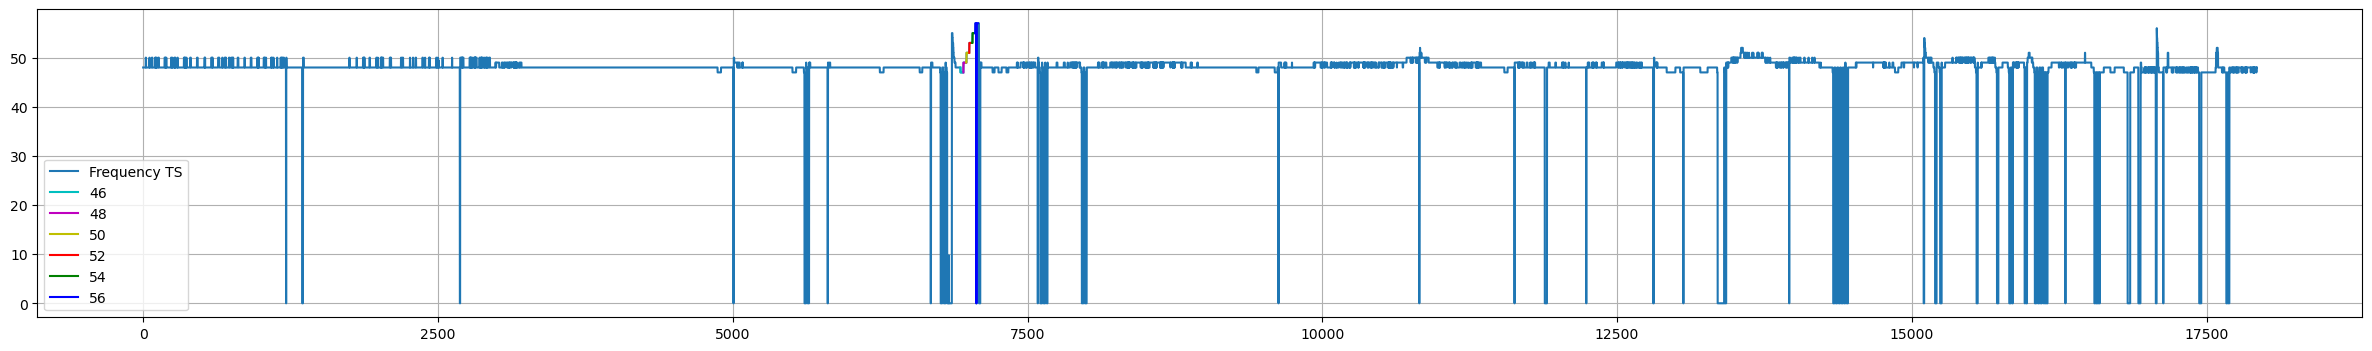

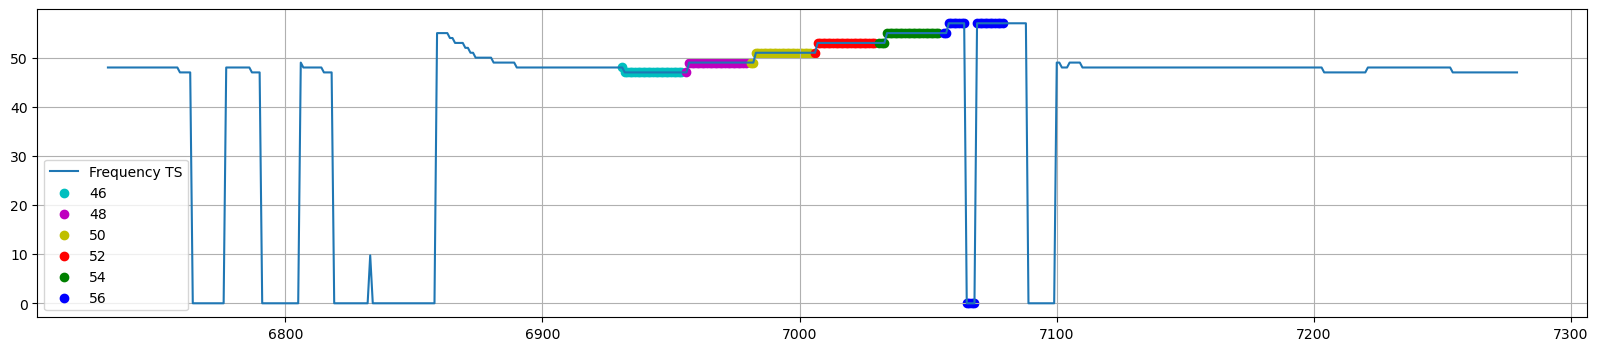

33467


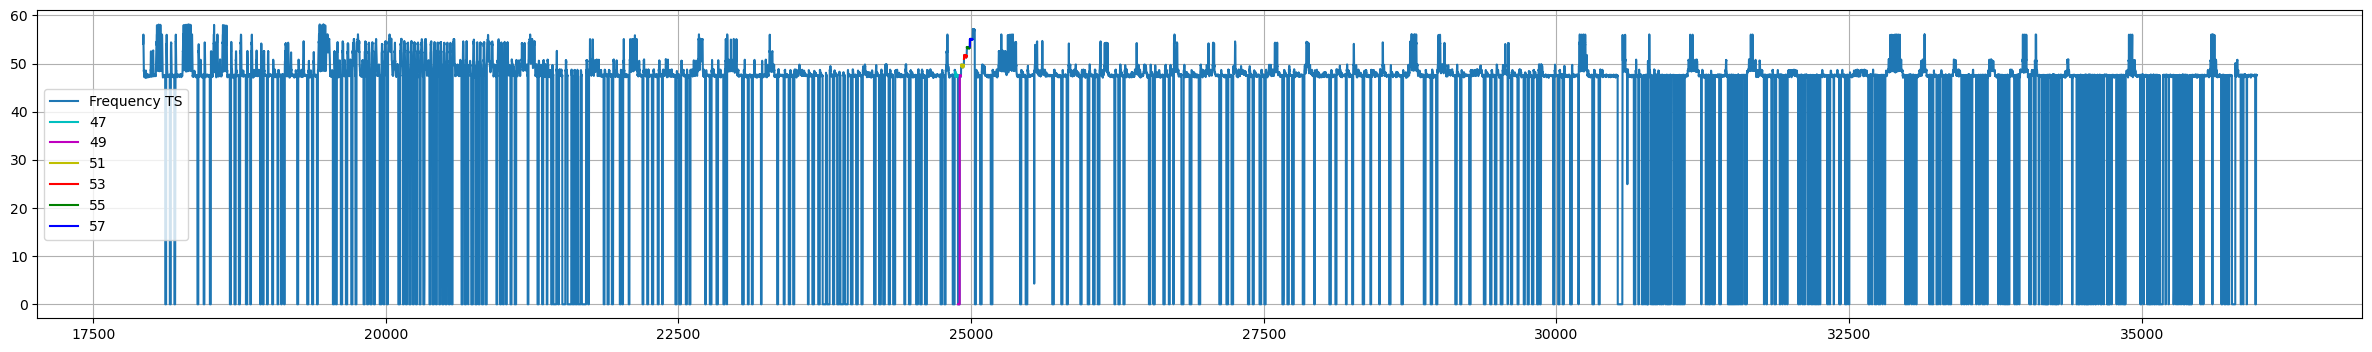

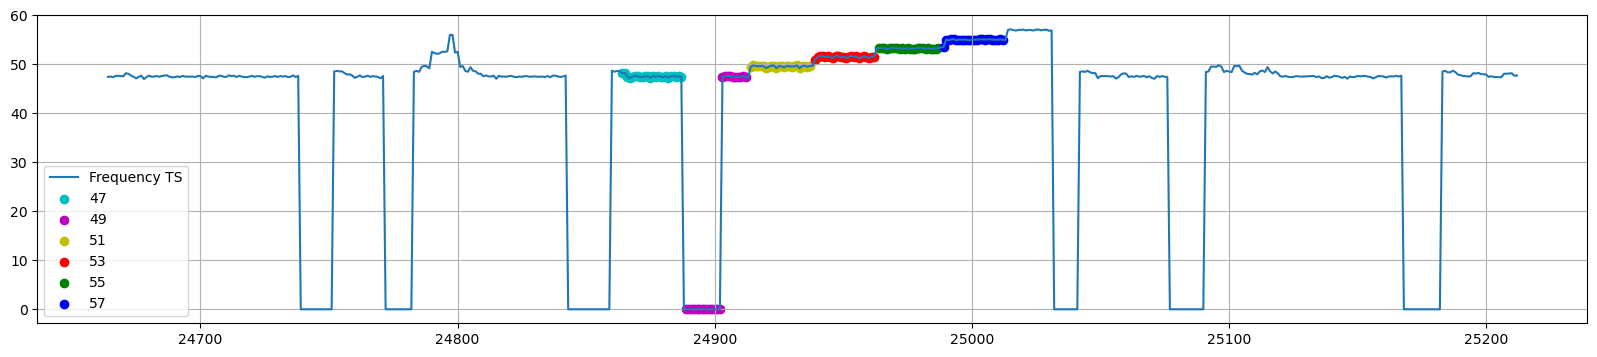

57740


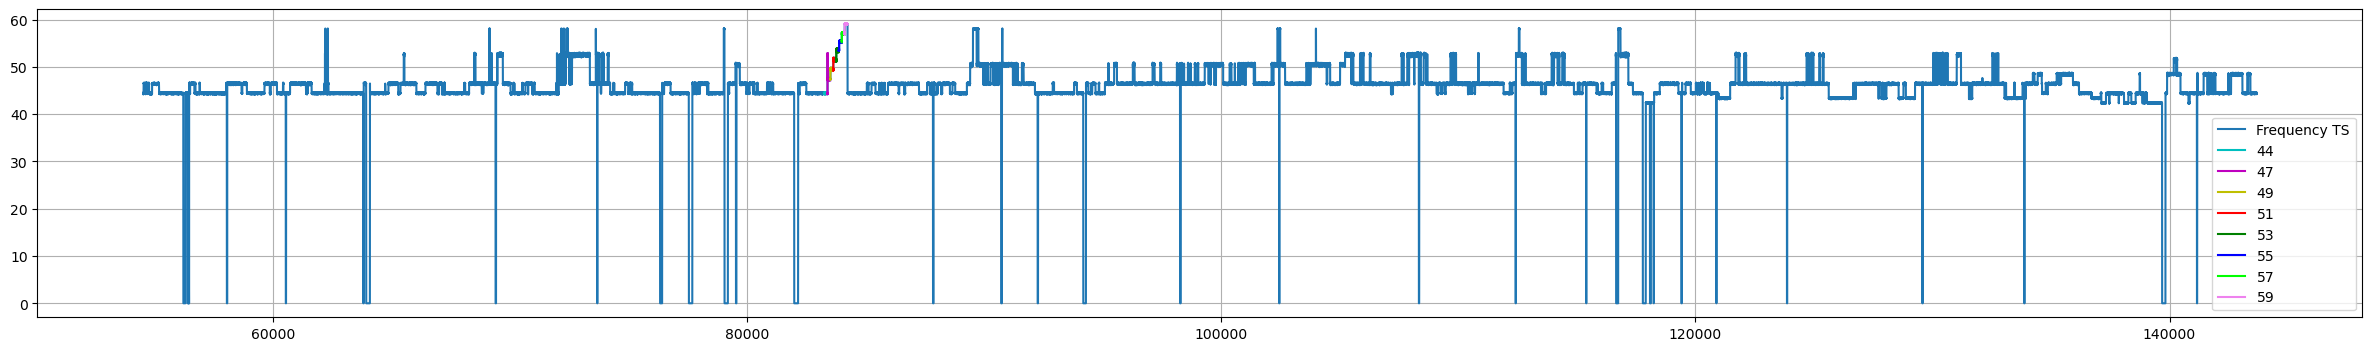

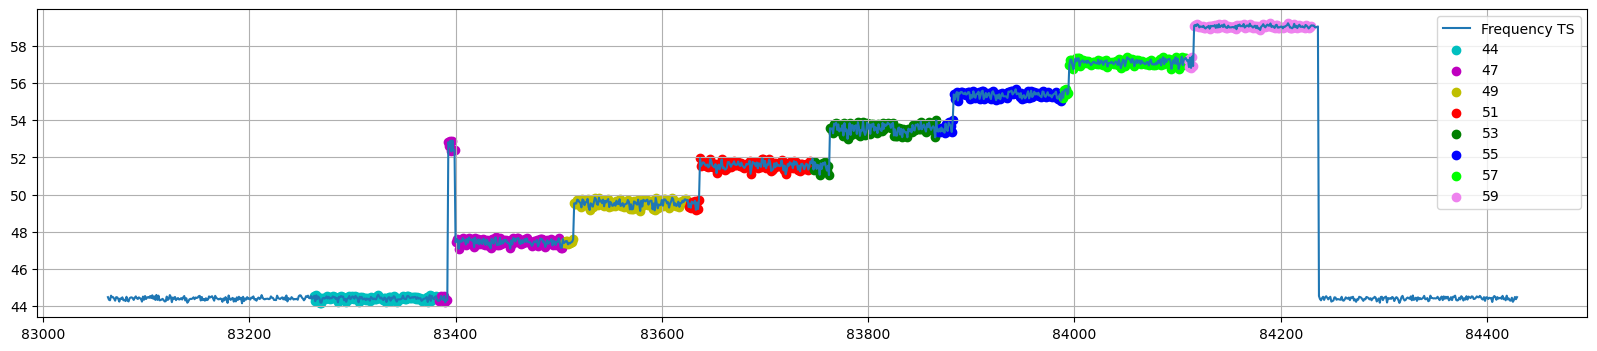

33614


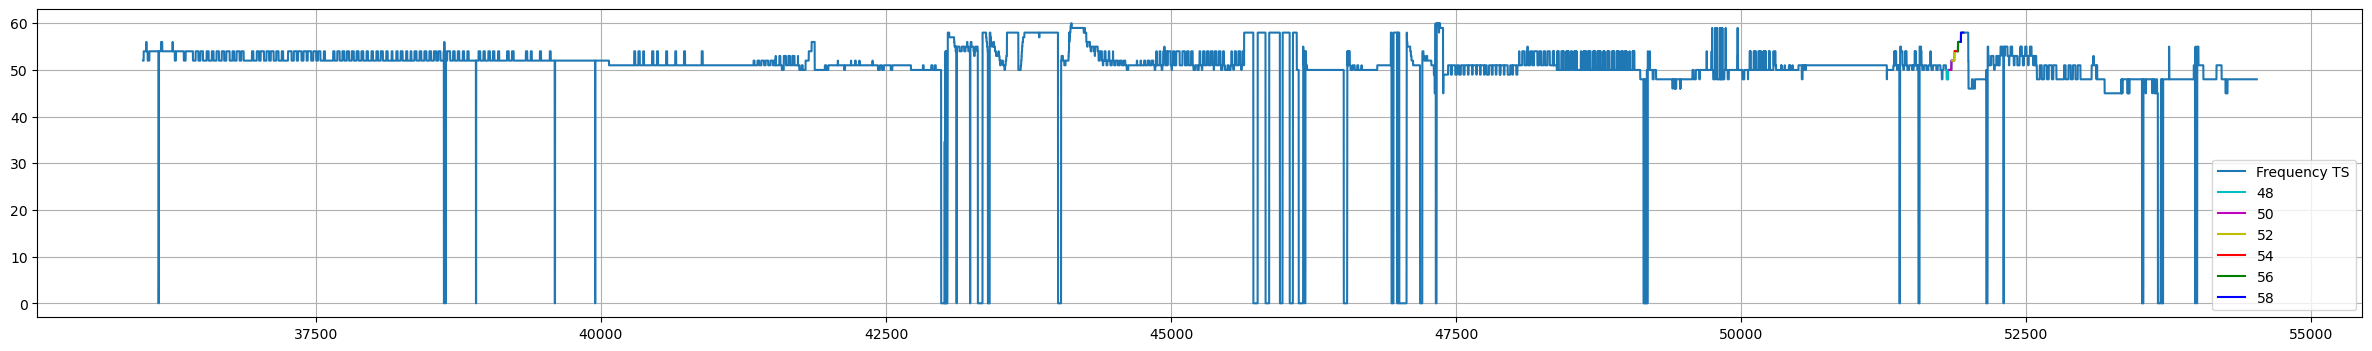

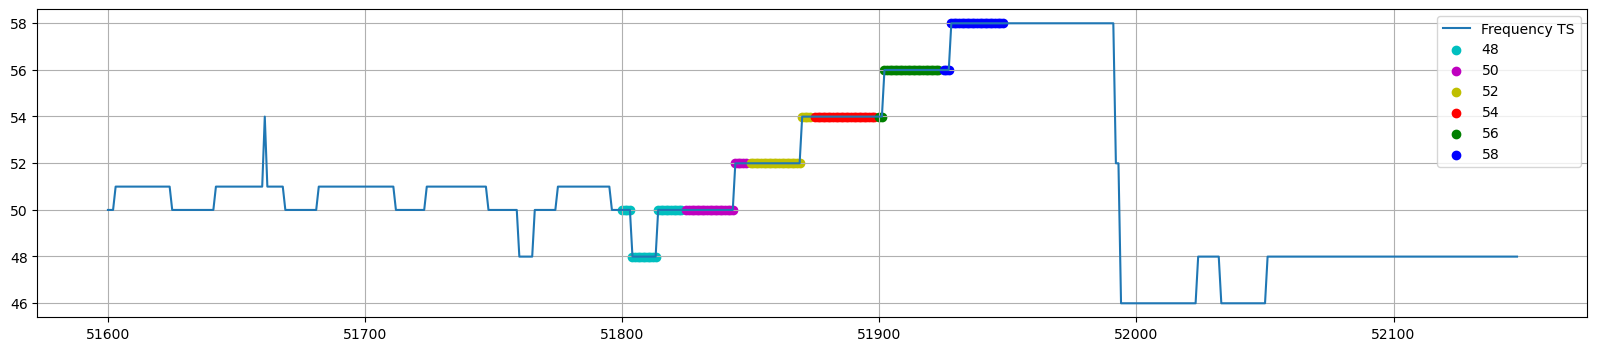

In [4]:
for site_id in sitegts.keys(): # 6
    print(site_id)
    freq_data = data['frequency']
    plot_ts_gt(sitegts, freq_data, site_id, site_bounds[site_id])

In [ ]:
# copied from sites_info: 
# https://github.com/neuralix-ai/dev_RyanMercer/blob/dev/notebooks/Customers/Bison/2024-12-29_Bison_PumpCurve_x-axisHealth_calibrated_alert.ipynb
ryan_cached_gt = cached_site_info() 
audrey_sitegts = deepcopy(sitegts)

print(ryan_cached_gt)
# np.savetxt("cached_gt.txt",ryan_cached_gt)
replace_this_every_week_ryan = ryan_format(data, ryan_cached_gt, audrey_sitegts)
# np.savetxt("replace_this_every_week.txt",replace_this_every_week_ryan)
print(replace_this_every_week_ryan)
# examine how the timestamps change from "my rough guess was about noon" --> "the precise time in the dataframe is 12:00:19"

In [ ]:
sampling_rates = {33404:twohr_rate_1_min, 33467:twohr_rate_5_min, 57740:twohr_rate_1_min, 33614:twohr_rate_5_min}
ryan_cached_to_audrey_format = ryan_site_info_to_audrey_format(data, ryan_cached_gt, sampling_rates)
print(ryan_cached_to_audrey_format)
replace_every_week_to_audrey_format = ryan_site_info_to_audrey_format(data, replace_this_every_week_ryan, sampling_rates)
print(replace_every_week_to_audrey_format)

# these are a tad different because ...
# ... I made time stamps mutually exclusive to a particular calibration frequency, whereas a calibration stage could start at 14:00:00 AND another could begin at 14:00:00